In [8]:
module('load', 'pytorch/gpu-cuda-12.1/2.2.0')

Loading pytorch/gpu-cuda-12.1/2.2.0
  Loading requirement: cuda/12.1 cudnn/8.9.2


In [88]:
import os
from config import PSFS_DIR
from astropy.io import fits
import torch

psf_name="devon_first_advice_psf_5_pix_16_arcsec"

psf_path = os.path.join(PSFS_DIR, psf_name + '.fits')

with fits.open(psf_path) as hdul:
                    psf_data = hdul[0].data
                    psf_data = psf_data.byteswap().newbyteorder()
            
            
psf_tensor = torch.from_numpy(psf_data).float().to("cuda")

pix_size= 0.0021
3820
38


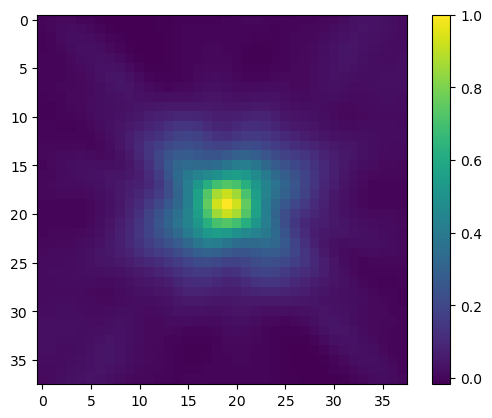

In [89]:
import matplotlib.pyplot as plt

tot_px=psf_tensor.shape[-1]
pix_size=8.0/tot_px #arcsec
print(f"pix_size= {pix_size:.4f}")
print(tot_px)
crop_fraction=0.01

new_dim=int(tot_px//(1/crop_fraction)//2*2)
print(new_dim)
low_bound=int((tot_px-new_dim)/2)
high_bound=int(tot_px-low_bound)

cropped_psf=psf_tensor[0][0][low_bound:high_bound, low_bound:high_bound]

cropped_psf_np=cropped_psf.detach().cpu().numpy()

plt.imshow(cropped_psf_np)
plt.colorbar()
plt.show()

In [90]:
# now fit a gaussian to the main lobe of the psf
import numpy as np

def gaussian_2d(coords, A, x0, y0, σx, σy, offset):
    """
    coords: tuple of (X, Y) meshgrids, each of shape (H, W)
    A: amplitude
    x0, y0: center
    σx, σy: standard deviations
    offset: constant background
    """
    X, Y = coords
    exponent = ((X - x0)**2)/(2*σx**2) + ((Y - y0)**2)/(2*σy**2)
    return offset + A * np.exp(-exponent)


data=cropped_psf_np
H, W = data.shape
Y, X = np.indices((H, W))  


total = data.sum()
x0 = (X * data).sum() / total
y0 = (Y * data).sum() / total

# rough σ from marginal variances
σx = np.sqrt(np.abs(((X - x0)**2 * data).sum()  / total))
σy = np.sqrt(np.abs(((Y - y0)**2 * data).sum()  / total))

A = data.max() - data.min()
offset = data.min()

initial_guess = (A, x0, y0, σx, σy, offset)

lb = [-np.inf, -np.inf, -np.inf,   0.0,   0.0, -np.inf]
ub = [ np.inf,  np.inf,  np.inf, np.inf, np.inf,  np.inf]


from scipy.optimize import curve_fit

# flatten everything
coords = np.vstack([X.ravel(), Y.ravel()])
values = data.ravel()

popt, pcov = curve_fit(
    gaussian_2d,
    coords,
    values,
    p0=initial_guess,
    bounds=(lb, ub)
)

A_fit, x0_fit, y0_fit, σx_fit, σy_fit, offset_fit = popt

In [91]:
print(f"σ_x = {σx_fit:.3f}  px")
print(f"σ_y = {σy_fit:.3f}  px")


σ_x = 4.492  px
σ_y = 3.939  px


In [92]:
print(f"σ_x = {σx_fit*pix_size:.3f}  arcsec")
print(f"σ_y = {σy_fit*pix_size:.3f}  arcsec")


σ_x = 0.009  arcsec
σ_y = 0.008  arcsec


526.9244739644904


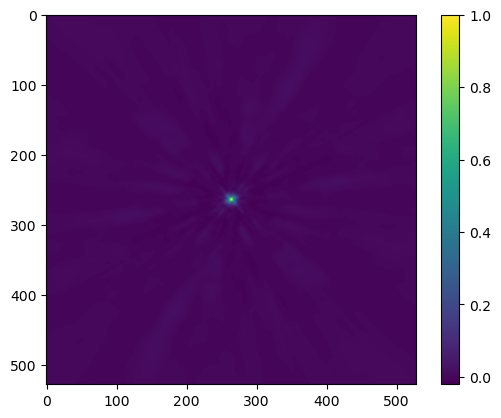

(528, 528)


In [103]:
# The input is of the dataloader is the image size and the size of the main lobe std

pix_size_image=100
arcsec_size_image=8.0
desired_std=0.8 #pixels
desired_std_arcsec=desired_std*(arcsec_size_image/pix_size_image)

main_lobe_std_pix=(σx_fit+σy_fit)/2
main_lobe_std_arcsec=main_lobe_std_pix*pix_size

# I need as many pixels as (standard deviations in tot image size)*number of pixel of 1 std


truncation_psf=(arcsec_size_image/desired_std_arcsec)*main_lobe_std_pix


low_bound=int((tot_px-truncation_psf)/2)
high_bound=int(tot_px-low_bound)

image_size_psf=(psf_tensor[0][0][low_bound:high_bound, low_bound:high_bound]).detach().cpu().numpy()

print(truncation_psf)


plt.imshow(image_size_psf)
plt.colorbar()
plt.show()


print(image_size_psf.shape)

